## Read in and setup data

We have the option of reading in and setting up data from two different sources:

* Yelp! Restaurant Reviews
* Amazon Magazine Reviews

### Yelp! Restaurant Reviews

Sometimes it's easiest to test everything out with a small amount of data. The tab delimited [Restaurant Reviews Dataset](http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv) is a common dataset that is used for natural language tasks that predict the sentiment of a given review.

I've provided a helper script (called [cs6220hw5.py](http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py)) that splits the data, standardizes the characters, and weeds out stop words, to parse and clean the text up, which should only be run once.

### Amazon Magazine Reviews

[This is the data for the homework](http://jmcauley.ucsd.edu/data/amazon/index_2014.html), which was released in 2014 and is slightly larger and may take some time to setup. We're only using the Magazine Subscriptions.

### Reference
* Jianmo Ni, Jiacheng Li, Julian McAuley, "*Justifying Recommendations using Distantly-Labeled Reviews and
Fine-Grained Aspects*", In Proceedings of **Empirical Methods in Natural Language Processing**, 2019

In [1]:
#@title Setup the Data (RUN ME)

# Which dataset to download?
dataset = 'magazines' # @param ["restaurant", "magazines"]

# Start with a clean slate
!rm -rf *
!wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py

# Import everything, including homework code
import numpy as np                                              # numpy array
import pandas as pd                                             # data science
import matplotlib.pyplot as plt                                 # matplotlib
import seaborn as sns                                           # plot style
from sklearn.metrics import confusion_matrix                    # confusion matrix
from sklearn.feature_extraction.text import CountVectorizer     # bag of words
from sklearn.model_selection import train_test_split            # train/test split
from sklearn.preprocessing import MinMaxScaler                  # scale data with min/max
from tqdm import tqdm_notebook as tqdm                          # download data utility
import json                                                     # amazon data in json
from IPython.display import clear_output
import cs6220hw5                                                # import cs6220

if dataset == 'restaurant':
  !wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv

  # Read the CSV data
  data = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

else:
  # Download from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
  !wget -nc https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Magazine_Subscriptions.json.gz
  !gunzip Magazine_Subscriptions.json.gz

  # Load data in
  reviews = []
  with open('Magazine_Subscriptions.json', 'r') as f:
      for l in tqdm(f):
          r = json.loads(l)
          reviews.append(r)

  # Format the data into Pandas DataFrame
  data = pd.DataFrame.from_records(reviews)[['reviewText', 'overall']]
  print("Initial data size: ", data.size)
  data = data[ data['overall'] != 3.0]
  data = data.rename(columns={"reviewText": "Review"})
  data['Liked'] = 0
  data.loc[data['overall'] > 3, 'Liked'] = 1
  data = data.dropna()

clear_output()
print("Data matrix has shape: ", data.shape)
data.head(10)

Data matrix has shape:  (82687, 3)


,Review,overall,Liked
0,"for computer enthusiast, MaxPC is a welcome si...",5.0,1
1,Thank god this is not a Ziff Davis publication...,5.0,1
3,This beautiful magazine is in itself a work of...,5.0,1
4,A great read every issue.,5.0,1
6,I've read Maximum PC (MPC) for many years. The...,5.0,1
7,We ordered this magazine for our grandson (the...,5.0,1
8,I have subscribed to the nook version for a fe...,4.0,1
9,"I'm old, and so is my computer. Any advice th...",4.0,1
10,"At one time, this was my least favorite comput...",5.0,1
11,I didn't receive a full year. I only receive ...,2.0,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82687 entries, 0 to 89688
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Review   82687 non-null  object 
 1   overall  82687 non-null  float64
 2   Liked    82687 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ MB


<Axes: >

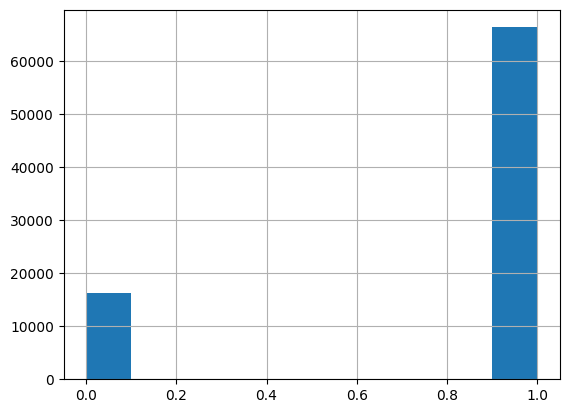

In [3]:
#@title Create a histogram of positive vs negative labels (YOUR CODE HERE)
data['Liked'].hist()

## Preprocess data

Here, you will:

* **Rebalance** the *training data* (leave the test dataset the same).
* **Clean up** the data: remove stopwords, punctuation, verb tense, etc.
* **Assign words** to a "bag of words" where each input feature is a histogram (count) of which words occur in the review.

To clean up the data, I have provided a function in [`cs6220hw5.py`](https://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py) called `clean_text`. Go ahead and take a look at what it does and explain. This takes a long time to run. What takes the most amount of time? Why?

You will notice in the "bag of words" featurization there are a lot of design decisions.

In [4]:
#@title Create splits & rebalance **training** data (YOUR CODE HERE)

test_size = 0.1 #@param
'''
You will need to

1. Split the training and test dataset to be 90 / 10%
2. Rebalance the training dataset so that it's 50/50
   positive / negative
'''

one_ratio = data.Liked.value_counts()[1]/(data.Liked.value_counts()[1]+data.Liked.value_counts()[0])
zero_ratio = 1 - one_ratio

data_l = np.random.choice(data[data.Liked==1].index, size=int(test_size*data.shape[0]*one_ratio), replace=False)
data_nl = np.random.choice(data[data.Liked==0].index, size=int(test_size*data.shape[0]*zero_ratio), replace=False)
exclude_list = np.concatenate((data_l, data_nl), axis=0)
testing_data = data.loc[exclude_list]

t_data = data[~data.index.isin(exclude_list)]
size = t_data.Liked.value_counts()[0]
training_data = pd.concat([t_data.loc[np.random.choice(t_data[t_data.Liked==1].index ,size=size, replace=False)],
           t_data[t_data.Liked==0]],
          axis = 0)


In [5]:
training_data.Liked.value_counts()

1    14626
0    14626
Name: Liked, dtype: int64

<Axes: >

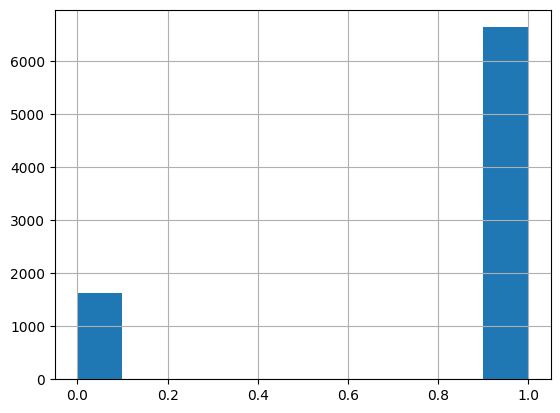

In [6]:
testing_data.Liked.hist()

In [7]:
#@title Clean text with `cs6220hw5.py`. (RUN ME & get some coffee; it takes a while.)

# The following code takes training data in the same format:
#    Review	| Stars |	Liked
training_corpus, testing_corpus = cs6220hw5.clean_text(training_data, testing_data)

### Explanation of the above code:
1. Frist the training and testing data is concatenated to do one cleaning.
2. All the non alphabetical characters are subsitituted for a space in the dataset using regular expressions.
3. All the characters in the dataset is made lowercase
4. Each review is split into array of words.
5. stemming is done on each word using the nltk library and portstemmer class. All the words that are not in the dictionary are stemmed.
6. Finally each review array of words after stemmed are joined back.
The slowest step in this process is the line below which does stemmatization for all the words. Checking with the big corpus for each word in the review is the most time intensive task.

    
    processed_reviews = processed_reviews.map(portstem)
    def portstem(review):
      return [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]

In [49]:
#@title Featurize into Bag of Words (Example Code)

# creating the count vectorizer model with max_features
vocab_size = 200                #@param
test_size = 0.3                 #@param
minmax_scale = True             #@param

cv = CountVectorizer(max_features = vocab_size)
x_train = cv.fit_transform(training_corpus).toarray()
y_train = np.array(training_data['Liked'])

x_test = cv.fit_transform(testing_corpus).toarray()
y_test = np.array(testing_data['Liked'])
# x_train = np.concatenate((x_train,np.array(training_data['overall']).reshape(-1,1)), axis=1)
# x_test = np.concatenate((x_test,np.array(testing_data['overall']).reshape(-1,1)), axis=1)
if minmax_scale:
  mm = MinMaxScaler()
  x_train = mm.fit_transform(x_train)
  x_test = mm.transform(x_test)


In [50]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.032258,0.000000
1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.166667
2,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.25,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.032258,0.000000
4,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.090909,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29247,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.090909,0.0,0.0,0.000000,0.000000
29248,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
29249,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
29250,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [39]:
from scipy.stats import pointbiserialr
features_needed=[]
for i in range(len(x_train[0])):
  pr = pointbiserialr(x_train[:,i], y_train)
  if(pr.statistic>0.1 or pr.statistic<-0.05):
    features_needed.append(i)

x_train = x_train[:,features_needed]
x_test = x_test[:,features_needed]

# Run all the algorithms

Play around with some thresholds. Because your evaluation dataset has the original distribution, play with that parameter. For each algorithm, print out:

* Accuracy
* Confusion Matrix
* Precision / Recall AUC

In [51]:
#@title Naive Bayes, Random Forest, Decision Tree Classifier, Logistic Regression (YOUR CODE HERE)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
data_store = {
    'models':['GaussianNB','RandomForest','DecisionTree', 'LogisticRegression', 'SVC', 'MLPClassifier'],
    'accuracy':[],
    'precision':[],
    'recall':[],
    'roc_auc':[],
    'f1_score':[]
}
train_models = [GaussianNB(),
                RandomForestClassifier(min_samples_leaf= 4, min_impurity_decrease= 0.0, max_features=0.5, n_estimators=250,random_state=2),
                DecisionTreeClassifier(random_state=2),
                LogisticRegression(solver= 'liblinear', penalty='l1', random_state=2),
                SVC(random_state=2),
                MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (10,30,10), alpha= 0.0001, activation= 'logistic',random_state=2)]

for model in train_models:
  clf = model
  clf.fit(x_train,y_train)
  y_pred = clf.predict(x_test)
  data_store['accuracy'].append(accuracy_score(y_test,y_pred))
  data_store['precision'].append(precision_score(y_test,y_pred))
  data_store['recall'].append(recall_score(y_test,y_pred))
  data_store['roc_auc'].append(roc_auc_score(y_test,y_pred))
  data_store['f1_score'].append(f1_score(y_test,y_pred))
  # print("Confustion Matrix for ", model)
  # print(confusion_matrix(y_test,y_pred))

results_df = pd.DataFrame(data_store)

In [53]:
results_df

,models,accuracy,precision,recall,roc_auc,f1_score
0,GaussianNB,0.645259,0.867181,0.659491,0.623284,0.749209
1,RandomForest,0.663038,0.909187,0.645040,0.690828,0.754667
2,DecisionTree,0.569908,0.873819,0.543128,0.611256,0.669885
3,LogisticRegression,0.595670,0.919207,0.544633,0.674471,0.683997
4,SVC,0.550556,0.926801,0.478398,0.661968,0.631056
5,MLPClassifier,0.563861,0.921923,0.499473,0.663275,0.647920


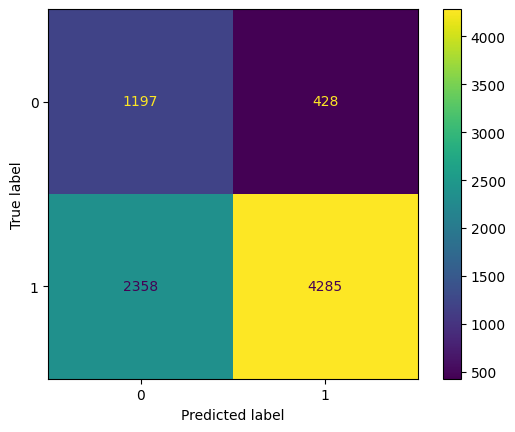

In [54]:
#Confustion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
best_model = RandomForestClassifier(min_samples_leaf= 4, min_impurity_decrease= 0.0, max_features=0.5, n_estimators=250,random_state=2)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

### Hyperparameter Tuning

In [ ]:
#From initial observation we see that almost all models perform similarly,
#the precision is around 85% but recall is down which decreases the overall accuracy too

#@title Enhancing Naive Bayes
priors = np.array([0.2,0.8])
clf = GaussianNB(priors=priors)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print('Accuracy:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_test,y_pred))
print('recall_score:',recall_score(y_test,y_pred))
print('roc_auc_score:',roc_auc_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))

Accuracy: 0.6480406386066764
precision_score: 0.8372177055103884
recall_score: 0.6975763962065332
roc_auc_score: 0.5715574288724974
f1_score: 0.761044506487108


0.7964583618214139


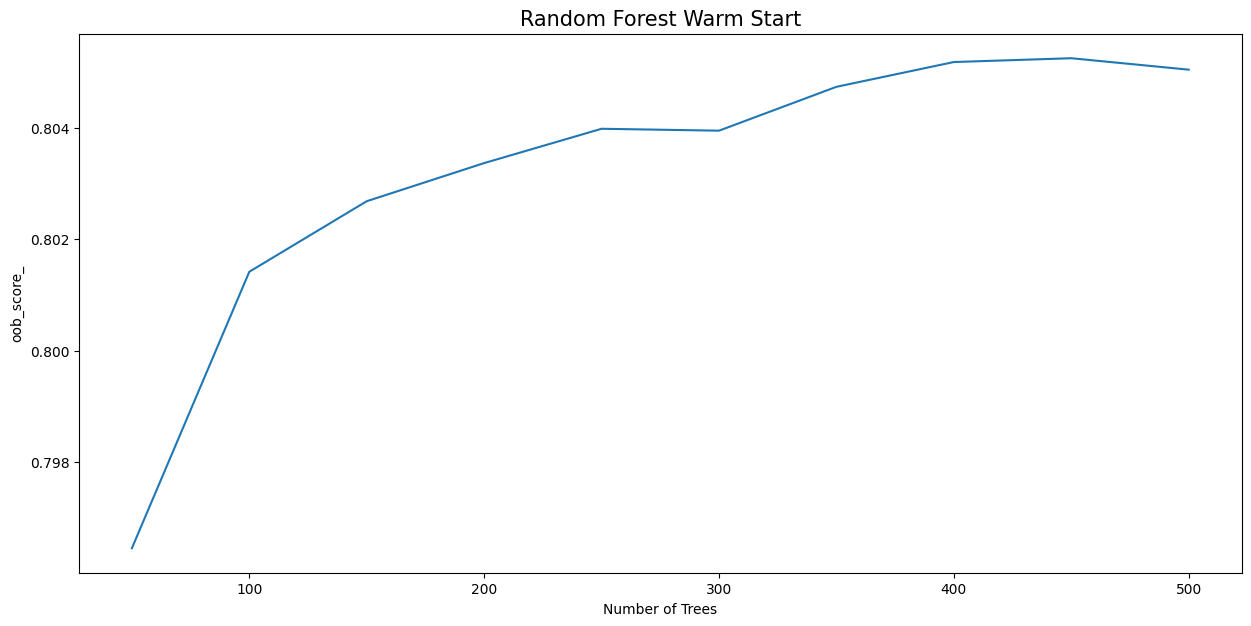

In [18]:
#@title Enhancing RandomForest Classifier - I
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
#Tuning Model
rf=RandomForestClassifier(random_state=3, n_jobs=-1, n_estimators=50, oob_score=True, warm_start=True)
rf.fit(x_train,y_train)
print(rf.oob_score_)
oob_s=[rf.oob_score_]
estimators=[50]
est=50
for i in range(9):
    est+=50
    rf.set_params(n_estimators=est)
    rf.fit(x_train, y_train)
    estimators.append(est)
    oob_s.append(rf.oob_score_)

plt.figure(figsize=(15,7))
plt.plot(estimators, oob_s)
plt.xlabel('Number of Trees')
plt.ylabel('oob_score_')
plt.title('Random Forest Warm Start', fontsize=15)
plt.savefig('Random_Forest_Warm_Start', dpi=325)
plt.show()

In [23]:
#@title Enhancing RandomForest Classifier - II
#Hyperparameter tuning done
def random_search( params, X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test, runs=14,  rf=RandomForestClassifier(random_state=5, n_jobs=-1) ):
    rmv = RandomizedSearchCV(rf , params, n_iter=runs, n_jobs=-1, cv=5, scoring='accuracy')
    rmv.fit(X_train, y_train)
    best_model = rmv.best_estimator_
    best_params = rmv.best_params_
    best_score = rmv.best_score_
    print(best_params,best_score)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    # Display the results
    print("Classification Report:")
    print(classification_rep)
# random_search(params={'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],'max_depth':[None,2,4,6,8,10,20]})
random_search(params={'max_features':[ 0.5, 0.4],'max_depth':[None,2,6,10], 'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2], 'min_samples_leaf': [1,2,4,6]})

{'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_features': 0.5, 'max_depth': None} 0.7923212833805895
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.77      0.40      1625
           1       0.90      0.49      0.64      6643

    accuracy                           0.55      8268
   macro avg       0.58      0.63      0.52      8268
weighted avg       0.77      0.55      0.59      8268



In [20]:
#@title Enhancing DecisionTrees Classifier
def param_search(params,runs=5, X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test):
    grid_reg = RandomizedSearchCV(DecisionTreeClassifier(random_state=2), params, n_iter=runs, scoring='accuracy', cv=5, n_jobs=-1, random_state=12)
    grid_reg.fit(X_train, y_train)
    print(grid_reg.best_params_, grid_reg.best_score_)

    model = grid_reg.best_estimator_
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    # Display the results
    print("Classification Report:")
    print(classification_rep)
# cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
# fig, ax = plt.subplots(figsize=(6, 4))
# cm_display.plot(ax=ax)
# plt.show()

param_search({'max_depth':[None,2,3,4,6,8,10,20]})

{'max_depth': None} 0.7388213746791769
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.61      0.34      1625
           1       0.85      0.52      0.65      6643

    accuracy                           0.54      8268
   macro avg       0.54      0.57      0.50      8268
weighted avg       0.73      0.54      0.59      8268



In [21]:
#@title Enhancing Logisitic Regression Classifier

#@title Enhancing DecisionTrees Classifier
def param_search(params,runs=15, X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test):
    grid_reg = RandomizedSearchCV(LogisticRegression(random_state=2), params, n_iter=runs, scoring='accuracy', cv=5, n_jobs=-1, random_state=12)
    grid_reg.fit(X_train, y_train)
    print(grid_reg.best_params_, grid_reg.best_score_)

    model = grid_reg.best_estimator_
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    # Display the results
    print("Classification Report:")
    print(classification_rep)
# cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
# fig, ax = plt.subplots(figsize=(6, 4))
# cm_display.plot(ax=ax)
# plt.show()

param_search({'penalty':['l1', 'l2', 'elasticnet', None],
              'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']})

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver

{'solver': 'liblinear', 'penalty': 'l1'} 0.7954319504153721
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.69      0.39      1625
           1       0.88      0.55      0.68      6643

    accuracy                           0.58      8268
   macro avg       0.58      0.62      0.54      8268
weighted avg       0.76      0.58      0.62      8268



In [22]:
#@title Enhancing  MLP Classifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

def param_search(params,runs=20, X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test):
    grid_reg = RandomizedSearchCV(MLPClassifier(random_state=2), params, n_iter=runs, scoring='accuracy', cv=5, n_jobs=-1, random_state=12)
    grid_reg.fit(X_train, y_train)
    print(grid_reg.best_params_, grid_reg.best_score_)

    model = grid_reg.best_estimator_
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    # Display the results
    print("Classification Report:")
    print(classification_rep)
# cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
# fig, ax = plt.subplots(figsize=(6, 4))
# cm_display.plot(ax=ax)
# plt.show()

param_search({'activation':['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive'],
              'hidden_layer_sizes': [(10,30,10),(20,)]})

{'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 30, 10), 'alpha': 0.0001, 'activation': 'logistic'} 0.8004573343441912
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.78      0.39      1625
           1       0.90      0.46      0.60      6643

    accuracy                           0.52      8268
   macro avg       0.58      0.62      0.50      8268
weighted avg       0.77      0.52      0.56      8268

